In [1]:
# experimental run that takes two images + transformation matrix + 3D coordinate
# will only run on config_lego_rotation

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import sys
import tensorflow as tf
import numpy as np
from scipy import sparse
import imageio
import json
import random
import time

from utils.run_nerf_helpers import *
from utils.config_parser import config_parser
from utils.load_llff import load_llff_data
from utils.load_deepvoxels import load_dv_data
from utils.load_blender import load_blender_data
from utils.load_shapenet import load_shapenet_data
from utils.load_stanford_car import load_stanford_car

from model.embedder import *
from model.models import *

tf.compat.v1.enable_eager_execution()

args = None
NEAR = 0.
FAR = 1.5

def batchify(fn, chunk):
    """Constructs a version of 'fn' that applies to smaller batches."""
    # chunck = batch size
    if chunk is None:
        return fn

    def ret(inputs):
        return tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    return ret


def compute_features(input_image, input_pose, encoder):
    # flatten input image
    image_original_shape = list(input_image.shape)
    input_image = np.reshape(input_image,[1, -1])
    input_image = tf.cast(input_image, tf.float32)

    # flatten input pose and add it to inputs
    # for pixelNerf architecture, no input pose is used
    # input_pose = np.reshape(input_pose,[1, -1])
    # input_pose = tf.cast(input_pose, tf.float32)

    # inputs = tf.concat([input_image, input_pose], -1)
    feature = encoder(input_image)
    # feature = tf.reshape(feature, [1] + image_original_shape[:-1] + [feature.shape[-1]])
    return feature


def run_network(inputs, pixel_coords, input_image, input_pose, viewdirs, network_fn, embed_fn, embeddirs_fn, netchunk=1024*64, feature=None, global_embed_fn=None):
    """
    Prepares inputs and applies network 'fn'.

    Input:
        inputs: 3D coordinates in world space of sampled points, shape [B, S, 3] where B=#batch, S=#sampled points for a pixel
        pixel_coords: the 2D pixel coordinates of those points, shape [B, 2]

    
    """

    if args.query_z_only:
        inputs_flat = tf.reshape(tf.norm(inputs,axis=-1),[-1,1]) # tf.reshape(inputs[...,-1],[-1,1]) 
    else:
        inputs_flat = tf.reshape(inputs, [-1, inputs.shape[-1]])

    embedded = embed_fn(inputs_flat)
    if viewdirs is not None:
        input_dirs = tf.broadcast_to(viewdirs[:, None], inputs.shape)
        input_dirs_flat = tf.reshape(input_dirs, [-1, input_dirs.shape[-1]])
        embedded_dirs = embeddirs_fn(input_dirs_flat)
        # viewing direction is also embedded
        embedded = tf.concat([embedded, embedded_dirs], -1)

    # if feature is None:
    feature = compute_features(input_image, input_pose, network_fn['encoder'])

    if args.add_global_feature:
        # additional global featrue is included as result
        feature, global_feature = feature

    if len(feature.shape) > 2:
        # returned feature is a volume, take samples for each pixel
        # for each query point, sample corresponding feature
        features_sampled = tf.gather_nd(feature[0,...],pixel_coords)
        features_sampled = tf.reshape(features_sampled,[-1, features_sampled.shape[-1]])
    else:
        # global feature vector
        features_sampled = tf.tile(feature, [embedded.shape[0],1])
    
    network_input = tf.concat([embedded, features_sampled], -1)

    if args.only_global_feature:
        dim = 1 if args.use_depth else 4
        outputs_flat = tf.zeros(list(inputs.shape[:-1]) + [dim])
    else:
        outputs_flat = network_fn['decoder'](network_input)
    outputs = tf.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])

    if args.add_global_feature:
        if global_embed_fn is None:
            global_embed = embedded
        else:
            inputs_flat = tf.reshape(inputs, [-1, inputs.shape[-1]])
            global_embed = global_embed_fn(inputs_flat)
            if viewdirs is not None:
                global_embed = tf.concat([global_embed, embedded_dirs], -1)

        global_feature_tiled = tf.tile(global_feature, [global_embed.shape[0], 1])
        global_network_input = tf.concat([global_embed, global_feature_tiled], -1)

        outputs_flat_global = network_fn['global_decoder'](global_network_input)
        outputs_global = tf.reshape(outputs_flat_global, list(inputs.shape[:-1]) + [outputs_flat_global.shape[-1]])
        outputs = [outputs, outputs_global]

    if args.use_depth:
        # if use depth, the model returns 1 channel output
        # need to manually expand it to 4 channels
        outputs = tf.concat([outputs,outputs,outputs,outputs],axis=-1)

    return outputs, feature


def create_nerf(args, hwf):
    """Instantiate NeRF's MLP model."""
    if args.query_z_only:
        input_dims = 1
        multires = args.multires * 3 + 2
    else:
        input_dims = 3
        multires = args.multires

    embed_fn, input_ch = get_embedder(multires, args.i_embed, input_dims=input_dims)

    global_embed_fn = None
    if args.add_global_feature:
        # global embed must use all xyz
        global_embed_fn, global_input_ch = get_embedder(args.multires, args.i_embed, input_dims=3)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(
            args.multires_views, args.i_embed)

    if args.use_depth:
        output_ch = 1
    else:
        output_ch = 4
    feature_skips = [1, 3]
    normal_skips = [5, 7]
    # skip specifies the indices of layers that need skip connection

    encoder = init_pixel_nerf_encoder(input_ch_image=(hwf[0],hwf[1],3), feature_depth=args.feature_len, 
                                      add_global_feature=args.add_global_feature, args=args)
    # feature_depth = encoder.outputs[0].shape[-1]

    decoder = init_pixel_nerf_decoder(D=args.netdepth, W=args.netwidth, 
                                      input_ch_coord=input_ch, 
                                      input_ch_views=input_ch_views, output_ch=output_ch, 
                                      feature_skips=feature_skips, normal_skips=normal_skips, feature_depth=args.feature_len, mode=args.skip_type)
    if args.fix_decoder:
        decoder.trainable = False

    models = {'encoder': encoder, 'decoder': decoder}

    global_decoder = None
    if args.add_global_feature:
        # add an extra global feature decoder
        global_decoder = init_pixel_nerf_decoder(D=args.netdepth, W=args.netwidth, 
                                      input_ch_coord=global_input_ch, 
                                      input_ch_views=input_ch_views, output_ch=output_ch, 
                                      feature_skips=feature_skips, normal_skips=normal_skips, feature_depth=args.feature_len, mode=args.skip_type)
        if args.fix_decoder:
            global_decoder.trainable = False
    
        models['global_decoder'] = global_decoder

    encoder.summary()
    decoder.summary()

    # fine model: only fine decoder needed
    decoder_fine  = None
    global_decoder_fine = None
    if args.N_importance > 0 and args.separate_fine:
        decoder_fine = init_pixel_nerf_decoder(D=args.netdepth, W=args.netwidth, 
                                      input_ch_coord=input_ch, 
                                      input_ch_views=input_ch_views, output_ch=output_ch, 
                                      feature_skips=feature_skips, normal_skips=normal_skips, feature_depth=args.feature_len, mode=args.skip_type)
        if args.fix_decoder:
            decoder_fine.trainable = False
        models['decoder_fine'] = decoder_fine
        

        if args.add_global_feature:
            # add an extra global feature decoder
            global_decoder_fine = init_pixel_nerf_decoder(D=args.netdepth, W=args.netwidth, 
                                        input_ch_coord=global_input_ch, 
                                        input_ch_views=input_ch_views, output_ch=output_ch, 
                                        feature_skips=feature_skips, normal_skips=normal_skips, feature_depth=args.feature_len, mode=args.skip_type)
            if args.fix_decoder:
                global_decoder_fine.trainable = False
            models['global_decoder_fine'] = global_decoder_fine


    def network_query_fn(inputs, pixel_coords, input_image, input_pose, viewdirs, network_fn, feature=None): return run_network(
        inputs, pixel_coords, input_image, input_pose, viewdirs, network_fn, feature=feature,
        embed_fn=embed_fn,
        embeddirs_fn=embeddirs_fn,
        netchunk=args.netchunk,
        global_embed_fn=global_embed_fn)

    render_kwargs_train = {
        'network_query_fn': network_query_fn,
        'perturb': args.perturb,
        'N_importance': args.N_importance,
        'network_fine': decoder_fine,
        'N_samples': args.N_samples,
        'network_fn': models,
        'use_viewdirs': args.use_viewdirs,
        'white_bkgd': args.white_bkgd,
        'raw_noise_std': args.raw_noise_std,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {
        k: render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.

    start = 0
    # start is batch counter
    basedir = args.basedir
    expname = args.expname

    if args.ft_path is not None and args.ft_path != 'None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if
                 ('encoder' in f)]
    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ft_weights = ckpts[-1]
        print('Reloading encoder from', ft_weights)
        models['encoder'].set_weights(np.load(ft_weights, allow_pickle=True))

        ft_weights_decoder = ft_weights.replace('encoder', 'decoder')
        print('Reloading decoder from', ft_weights_decoder)
        models['decoder'].set_weights(np.load(ft_weights_decoder, allow_pickle=True))

        # ft_weights_optimizer = ft_weights.replace('encoder', 'optimizer')
        # print('Reloading optimizer from', ft_weights_optimizer)
        # models['optimizer'].set_weights(np.load(ft_weights_optimizer, allow_pickle=True))

        start = int(ft_weights[-10:-4]) + 1
        print('Resetting step to', start)

        # load weights for fine decoder
        if decoder_fine is not None:            
            ft_weights_decoder_fine = ft_weights.replace('encoder', 'decoder_fine')
            print('Reloading decoder_fine from', ft_weights_decoder_fine)
            models['decoder_fine'].set_weights(np.load(ft_weights_decoder_fine, allow_pickle=True))

        if global_decoder is not None:
            ft_weights_global_decoder = ft_weights.replace('encoder', 'global_decoder')
            print('Reloading global_decoder from', ft_weights_global_decoder)
            models['global_decoder'].set_weights(np.load(ft_weights_global_decoder, allow_pickle=True))

        if global_decoder_fine is not None:
            ft_weights_global_decoder_fine = ft_weights.replace('encoder', 'global_decoder_fine')
            print('Reloading global_decoder_fine from', ft_weights_global_decoder_fine)
            models['global_decoder_fine'].set_weights(np.load(ft_weights_global_decoder_fine, allow_pickle=True))


    return render_kwargs_train, render_kwargs_test, start, models


def render_rays(ray_batch,
                input_image,
                input_pose,
                network_fn,
                network_query_fn,
                N_samples,
                retraw=False,
                lindisp=False,
                perturb=0.,
                N_importance=0,
                network_fine=None,
                white_bkgd=False,
                raw_noise_std=0.,
                verbose=False,
                hwf=None):
    """Volumetric rendering.

    Args:
      ray_batch: array of shape [batch_size, ...]. All information necessary
        for sampling along a ray, including: ray origin, ray direction, min
        dist, max dist, and unit-magnitude viewing direction.
      network_fn: function. Model for predicting RGB and density at each point
        in space.
      network_query_fn: function used for passing queries to network_fn.
      N_samples: int. Number of different times to sample along each ray.
      retraw: bool. If True, include model's raw, unprocessed predictions.
      lindisp: bool. If True, sample linearly in inverse depth rather than in depth.
      perturb: float, 0 or 1. If non-zero, each ray is sampled at stratified
        random points in time.
      N_importance: int. Number of additional times to sample along each ray.
        These samples are only passed to network_fine.
      network_fine: "fine" network with same spec as network_fn.
      white_bkgd: bool. If True, assume a white background.
      raw_noise_std: ...
      verbose: bool. If True, print more debugging info.

    Returns:
      rgb_map: [num_rays, 3]. Estimated RGB color of a ray. Comes from fine model.
      disp_map: [num_rays]. Disparity map. 1 / depth.
      acc_map: [num_rays]. Accumulated opacity along each ray. Comes from fine model.
      raw: [num_rays, num_samples, 4]. Raw predictions from model.
      rgb0: See rgb_map. Output for coarse model.
      disp0: See disp_map. Output for coarse model.
      acc0: See acc_map. Output for coarse model.
      z_std: [num_rays]. Standard deviation of distances along ray for each
        sample.
    """

    def raw2outputs(raw, z_vals, rays_d):
        """Transforms model's predictions to semantically meaningful values.

        Args:
          raw: [num_rays, num_samples along ray, 4]. Prediction from model.
          z_vals: [num_rays, num_samples along ray]. Integration time.
          rays_d: [num_rays, 3]. Direction of each ray.

        Returns:
          rgb_map: [num_rays, 3]. Estimated RGB color of a ray.
          disp_map: [num_rays]. Disparity map. Inverse of depth map.
          acc_map: [num_rays]. Sum of weights along each ray.
          weights: [num_rays, num_samples]. Weights assigned to each sampled color.
          depth_map: [num_rays]. Estimated distance to object.
        """
        # Function for computing density from model prediction. This value is
        # strictly between [0, 1].
        def raw2alpha(raw, dists, act_fn=tf.nn.relu): return 1.0 - \
            tf.exp(-act_fn(raw) * dists)

        if args.add_global_feature:
            # if using global feature, return raw is an array
            raw, raw_global = raw

        # Compute 'distance' (in time) between each integration time along a ray.
        dists = z_vals[..., 1:] - z_vals[..., :-1]

        # The 'distance' from the last integration time is infinity.
        dists = tf.concat(
            [dists, tf.broadcast_to([1e10], dists[..., :1].shape)],
            axis=-1)  # [N_rays, N_samples]

        # Multiply each distance by the norm of its corresponding direction ray
        # to convert to real world distance (accounts for non-unit directions).
        dists = dists # * tf.linalg.norm(rays_d[..., None, :], axis=-1)

        # Extract RGB of each sample position along each ray.
        rgb = tf.math.sigmoid(raw[..., :3])  # [N_rays, N_samples, 3]

        # Add noise to model's predictions for density. Can be used to 
        # regularize network during training (prevents floater artifacts).
        noise = 0.
        if raw_noise_std > 0.:
            noise = tf.random.normal(raw[..., 3].shape) * raw_noise_std

        # Predict density of each sample along each ray. Higher values imply
        # higher likelihood of being absorbed at this point.
        alpha = raw2alpha(raw[..., 3] + noise, dists)  # [N_rays, N_samples]

        if args.add_global_feature:
            # calculate rgb and density for global predictions as well
            rgb_global = tf.math.sigmoid(raw_global[..., :3])
            alpha_global = raw2alpha(raw_global[..., 3] + noise, dists)

            if args.only_global_feature:
                rgb = rgb_global
                alpha = alpha_global
            else:
                alpha_non_zero = tf.where(tf.equal(alpha,0), 1e-10*tf.ones_like(alpha), alpha)
                alpha_global_non_zero = tf.where(tf.equal(alpha_global,0), 1e-10*tf.ones_like(alpha_global), alpha_global)

                # take the weighted average of rgb and sum of density
                local_weights = (alpha_non_zero / (alpha_non_zero + alpha_global_non_zero))[...,None]
                rgb = rgb * local_weights + rgb_global * (1-local_weights)

                local_adjustment = (alpha - 0.5) / 5
                # alpha = tf.clip_by_value(local_adjustment + alpha_global,0,1)
                alpha = (alpha + alpha_global)/2


        # Compute weight for RGB of each sample along each ray.  A cumprod() is
        # used to express the idea of the ray not having reflected up to this
        # sample yet.
        # [N_rays, N_samples]
        weights = alpha * \
            tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True)

        # Computed weighted color of each sample along each ray.
        rgb_map = tf.reduce_sum(
            weights[..., None] * rgb, axis=-2)  # [N_rays, 3]

        # Estimated depth map is expected distance.
        depth_map = tf.reduce_sum(weights * z_vals, axis=-1)

        # Disparity map is inverse depth.
        disp_map = 1./tf.maximum(1e-10, depth_map /
                                 tf.reduce_sum(weights, axis=-1))

        # Sum of weights along each ray. This value is in [0, 1] up to numerical error.
        acc_map = tf.reduce_sum(weights, -1)

        # To composite onto a white background, use the accumulated alpha map.
        if white_bkgd:
            rgb_map = rgb_map + (1.-acc_map[..., None])

        return rgb_map, disp_map, acc_map, weights, depth_map

    ###############################

    input_pose = tf.convert_to_tensor(input_pose)
    input_image = tf.convert_to_tensor(input_image)
    
    # batch size
    N_rays = ray_batch.shape[0]

    # Extract ray origin, direction.
    rays_o, rays_d = ray_batch[:, 0:3], ray_batch[:, 3:6]  # [N_rays, 3] each

    # TODO: find out if this affects original nerf
    rays_d = ray_batch[:, 8:] # use normalized rays_d

    # Extract unit-normalized viewing direction.
    # note that viewdirs are same as rays_d, it's used here just for no_view_dir case
    viewdirs = ray_batch[:, -3:] if ray_batch.shape[-1] > 8 else None

    # Extract lower, upper bound for ray distance.
    bounds = tf.reshape(ray_batch[..., 6:8], [-1, 1, 2])
    near, far = bounds[..., 0], bounds[..., 1] 

    # Decide where to sample along each ray. Under the logic, all rays will be sampled at
    # the same times.

    # modified to exclude distance 0
    t_vals = tf.linspace(0., 1., N_samples+1)[1:]
    if not lindisp:
        # Space integration times linearly between 'near' and 'far'. Same
        # integration points will be used for all rays.
        z_vals = near * (1.-t_vals) + far * (t_vals)
    else:
        # Sample linearly in inverse depth (disparity).
        z_vals = 1./(1./near * (1.-t_vals) + 1./far * (t_vals))
    z_vals = tf.broadcast_to(z_vals, [N_rays, N_samples])

    # Perturb sampling time along each ray.
    if perturb > 0.:
        # get intervals between samples
        mids = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        upper = tf.concat([mids, z_vals[..., -1:]], -1)
        lower = tf.concat([z_vals[..., :1], mids], -1)
        # stratified samples in those intervals
        t_rand = tf.random.uniform(z_vals.shape)
        z_vals = lower + (upper - lower) * t_rand

    # Points in space to evaluate model at.
    pts = rays_o[..., None, :] + rays_d[..., None, :] * \
        z_vals[..., :, None]  # [N_rays, N_samples, 3

    def transform_coord_sys(vecs, input_pose):
        '''
        Transform 3D points into input view's coordinate system. Full transformation (rot+trans) is used.

        Input:
            vecs: (B,S,3) vectors of 3D coordinates. #S is the number of samples
            input_pose: input view's coordinate system of shape (3, 4)
        '''
        # convert those points from world coordinate to input view camera coordiate
        input_pose_full = tf.concat([input_pose,[[0,0,0,1]]], axis=0)

        vecs_input_view = tf.transpose(tf.reshape(vecs, (-1, 3)))
        vecs_input_view = tf.concat([vecs_input_view, tf.ones([1, vecs_input_view.shape[-1]])],axis=0)

        vecs_input_view = tf.linalg.inv(input_pose_full) @ vecs_input_view # TODO: make sure it works

        vecs_input_view = tf.transpose(vecs_input_view[:3,:])
        vecs_input_view = tf.reshape(vecs_input_view, vecs.shape)

        return vecs_input_view

    def transform_coord_sys_dirs(vecs, input_pose):
        '''
        Transform view dirs into input view's coordinate system. Only rotation is used for this translation

        Input:
            vecs: (B,S,3) vectors of view dirs. #S is the number of samples
            input_pose: input view's coordinate system of shape (3, 4)
        '''
        # convert those vectors from world coordinate to input view camera coordiate
        vecs_input_view = tf.transpose(tf.reshape(vecs, (-1, 3)))

        vecs_input_view = tf.linalg.inv(input_pose[:3,:3]) @ vecs_input_view

        vecs_input_view = tf.transpose(vecs_input_view[:3,:])
        vecs_input_view = tf.reshape(vecs_input_view, vecs.shape)

        # normalize for view dirs
        vecs_input_view = vecs_input_view / tf.math.reduce_sum(vecs_input_view**2, axis=-1, keepdims=True)**0.5

        return vecs_input_view

    def find_pixel_coords(pts_input_view, hwf):
        '''
        Find the corresponding pixel coordinates for the point
        '''
        ray_dirs_input_view = pts_input_view # because all pts are in input view coordinate system
        ray_dirs_input_view_norm = ray_dirs_input_view / (-1 * ray_dirs_input_view[...,-1:])

        ray_dirs_input_view_clamp = tf.clip_by_value(ray_dirs_input_view_norm[...,:2],-0.5,0.5) # clamp for pts that fall outside of the range

        H,W,focal = hwf

        pixel_coords = ray_dirs_input_view_clamp.numpy()
        pixel_coords[...,0] = ray_dirs_input_view_clamp[...,0] * focal + 0.5*W
        pixel_coords[...,1] = 0.5*H - ray_dirs_input_view_clamp[...,1] * focal
        pixel_coords = tf.convert_to_tensor(pixel_coords)
        pixel_coords = tf.cast(pixel_coords,tf.int32)
        pixel_coords = tf.clip_by_value(pixel_coords,0,np.max([H,W]))

        return pixel_coords
    
    pts_input_view = transform_coord_sys(pts, input_pose)
    viewdirs_input_view = transform_coord_sys_dirs(viewdirs, input_pose)

    pixel_coords = find_pixel_coords(pts_input_view, hwf)

    # Evaluate model at each point.
    raw, feature = network_query_fn(pts_input_view, pixel_coords, input_image, input_pose, viewdirs_input_view, network_fn)  # [N_rays, N_samples, 4]
    rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
        raw, z_vals, rays_d)

    if args.use_depth:
        # if use depth for training, discard rgb output
        rgb_map = depth_map

        rgb_map = tf.concat([rgb_map[:,None],rgb_map[:,None],rgb_map[:,None]],axis=-1)
        rgb_map = rgb_map / FAR # divide by far bound so the value remains in range 0 ~ 1 

    if N_importance > 0:
        # _0 are the coarse estimation if N_impoartance > 0
        rgb_map_0, disp_map_0, acc_map_0  = rgb_map, disp_map, acc_map

        # Obtain additional integration times to evaluate based on the weights
        # assigned to colors in the coarse model.
        z_vals_mid = .5 * (z_vals[..., 1:] + z_vals[..., :-1])
        z_samples = sample_pdf(
            z_vals_mid, weights[..., 1:-1], N_importance, det=(perturb == 0.))
        z_samples = tf.stop_gradient(z_samples)

        # Obtain all points to evaluate color, density at.
        z_vals = tf.sort(tf.concat([z_vals, z_samples], -1), -1)
        pts = rays_o[..., None, :] + rays_d[..., None, :] * \
            z_vals[..., :, None]  # [N_rays, N_samples + N_importance, 3]


        pts_input_view = transform_coord_sys(pts, input_pose)
        viewdirs_input_view = transform_coord_sys_dirs(viewdirs, input_pose)

        pixel_coords = find_pixel_coords(pts_input_view, hwf)

        # Make predictions with network_fine if it exists
        run_fn = network_fn if network_fine is None else {'encoder': network_fn['encoder'], 'decoder': network_fine}
        # if use additional global feature, also need to include global find decoder
        if args.add_global_feature:
            run_fn['global_decoder'] = network_fn['global_decoder_fine']

        # re-use the same feature
        raw, _ = network_query_fn(pts_input_view, pixel_coords, input_image, input_pose, viewdirs_input_view, run_fn, feature=feature)
        rgb_map, disp_map, acc_map, weights, depth_map = raw2outputs(
            raw, z_vals, rays_d)

        if args.use_depth:
            rgb_map = depth_map
            rgb_map = tf.concat([rgb_map[:,None],rgb_map[:,None],rgb_map[:,None]],axis=-1) # TODO
            # normalize to fit the far/near bound
            rgb_map = rgb_map / far

    ret = {'rgb_map': rgb_map, 'disp_map': disp_map, 'acc_map': acc_map, 'feature': feature}
    if retraw:
        if args.add_global_feature:
            raw = tf.concat(raw,axis=-1)
        ret['raw'] = raw
    if N_importance > 0:
        ret['rgb0'] = rgb_map_0
        ret['disp0'] = disp_map_0
        ret['acc0'] = acc_map_0
        ret['z_std'] = tf.math.reduce_std(z_samples, -1)  # [N_rays]

    for k in ret:
        tf.debugging.check_numerics(ret[k], 'output {}'.format(k))

    return ret


def render(H, W, focal,
           chunk=1024*32, rays=None, image=None, 
           pose=None, c2w=None, ndc=True,
           near=0., far=1.,
           use_viewdirs=False, c2w_staticcam=None,
           **kwargs):
    """Render rays

    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.

      pose: c2w tranformation matrix of input image

      c2w: array of shape [3, 4]. Camera-to-world transformation matrix of target view.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for 
       camera while using other c2w argument for viewing directions.

    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """

    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, focal, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)

        # Make all directions unit magnitude.
        # shape: [batch_size, 3]
        viewdirs = viewdirs / tf.linalg.norm(viewdirs, axis=-1, keepdims=True)
        viewdirs = tf.cast(tf.reshape(viewdirs, [-1, 3]), dtype=tf.float32)

    sh = rays_d.shape  # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(
            H, W, focal, tf.cast(1., tf.float32), rays_o, rays_d)

    # Create ray batch
    rays_o = tf.cast(tf.reshape(rays_o, [-1, 3]), dtype=tf.float32)
    rays_d = tf.cast(tf.reshape(rays_d, [-1, 3]), dtype=tf.float32)
    near, far = near * \
        tf.ones_like(rays_d[..., :1]), far * tf.ones_like(rays_d[..., :1])

    # (ray origin, ray direction, min dist, max dist) for each ray
    rays = tf.concat([rays_o, rays_d, near, far], axis=-1)
    if use_viewdirs:
        # (ray origin, ray direction, min dist, max dist, normalized viewing direction)
        rays = tf.concat([rays, viewdirs], axis=-1)


    def batchify_rays(rays_flat, image, pose, chunk=1024*32, **kwargs):
        """Render rays in smaller minibatches to avoid OOM."""
        all_ret = {}
        for i in range(0, rays_flat.shape[0], chunk):
            ret = render_rays(rays_flat[i:i+chunk], image, pose, **kwargs, hwf=[H, W, focal])
            for k in ret:
                if k not in all_ret:
                    all_ret[k] = []
                all_ret[k].append(ret[k])

        all_ret = {k: tf.concat(all_ret[k], 0) for k in all_ret}
        return all_ret

    # Render and reshape
    all_ret = batchify_rays(rays, image, pose, chunk, **kwargs)
    for k in all_ret:
        if 'feature' not in k:
            k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
            all_ret[k] = tf.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map', 'feature']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k: all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]


def render_path(render_poses, hwf, chunk, render_kwargs, input_image=None, pose=None, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor != 0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(render_poses):
        # print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, feature, _ = render(
            H, W, focal, image=input_image, pose=pose, chunk=chunk, c2w=c2w[:3, :4], **render_kwargs)
        rgbs.append(rgb.numpy())
        disps.append(disp.numpy())
        # if i == 0:
        #     print(rgb.shape, disp.shape)

        if gt_imgs is not None and render_factor == 0:
            p = -10. * np.log10(np.mean(np.square(rgb - gt_imgs[i])))
            # print(p)

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)

    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps


ID 0: 00166.jpg:


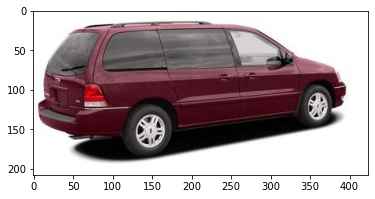

ID 1: 00022.jpg:


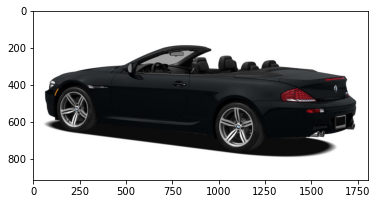

ID 2: 00062.jpg:


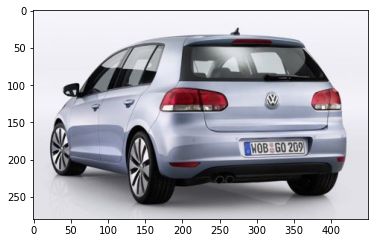

ID 3: 00076.jpg:


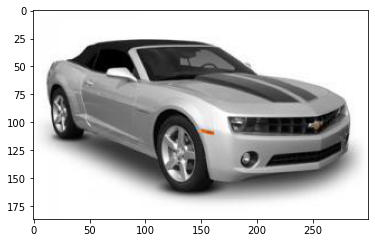

ID 4: 00146.jpg:


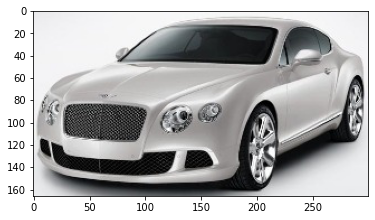

ID 5: 00169.jpg:


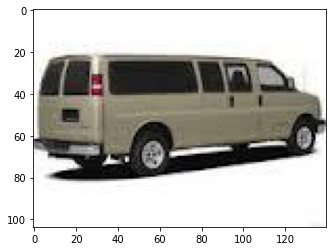

ID 6: 00178.jpg:


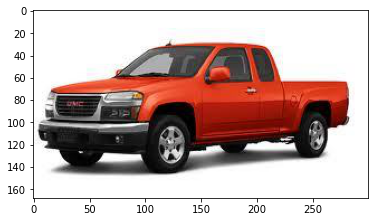

ID 7: 00348.jpg:


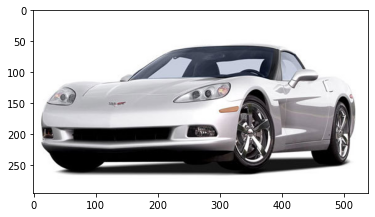

ID 8: 00472.jpg:


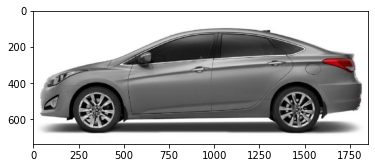

ID 9: 00475.jpg:


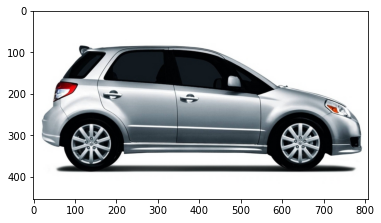

ID 10: 00748.jpg:


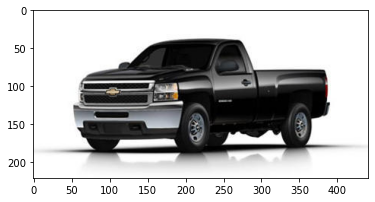

ID 11: 097500_obj_0_ground_truth.png:


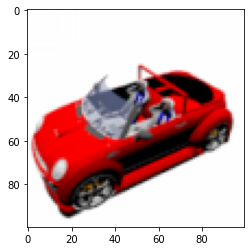

ID 12: 200000_ground_truth_val.png:


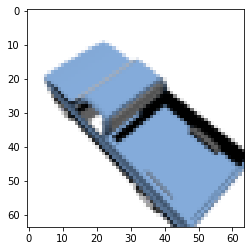

ID 13: blender-005652.color.png:


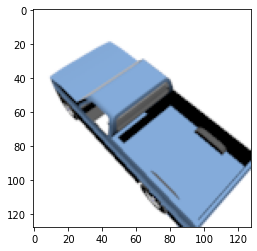

ID 14: 01066.jpg:


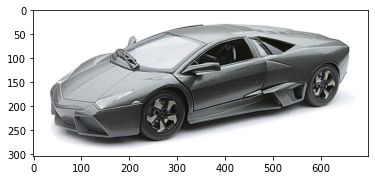

ID 15: 00563.jpg:


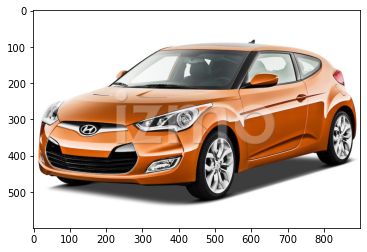

ID 16: 00896.jpg:


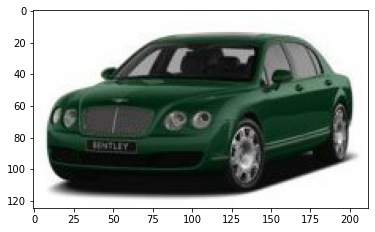

ID 17: 00949.jpg:


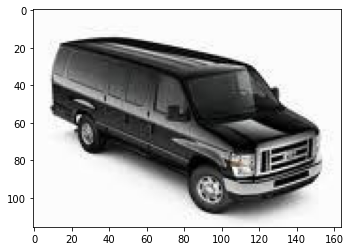

ID 18: blender-005643.color.png:


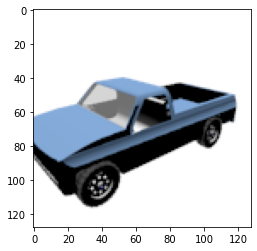

ID 19: filtered_00881.jpg:


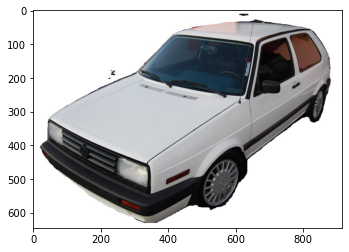

ID 20: filtered_00034.jpg:


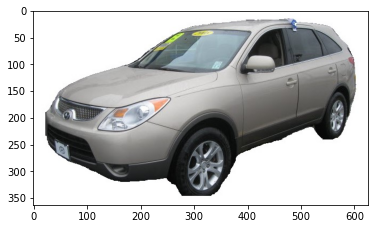

ID 21: filtered_00018.jpg:


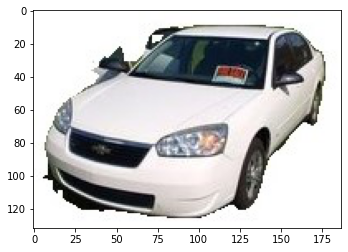

ID 22: filtered_00002.jpg:


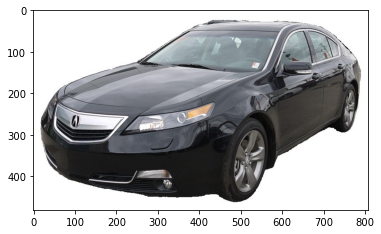

ID 23: filtered_00376.jpg:


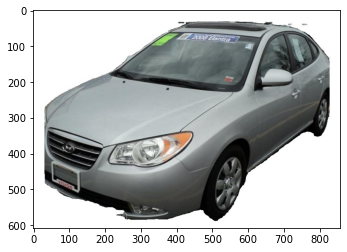

In [13]:
import pdb
from utils.load_stanford_car import *
from IPython.display import Video
import matplotlib.pyplot as plt

imgs_dir = './data/stanford_car_cropped/'

img_names = [name for name in os.listdir(imgs_dir) if name.endswith('.jpg') or name.endswith('.png')]

for i,img_name in enumerate(img_names):
    print(f'ID {i}: {img_name}:')
    plt.imshow(imageio.imread(os.path.join(imgs_dir,img_name)))
    plt.show()

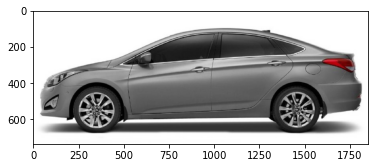

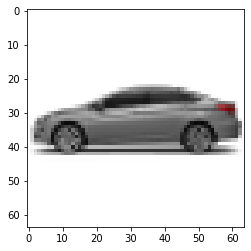

In [7]:
##### --------------setting--------------
parser = config_parser()
args = parser.parse_args("--config configs/config_car_full_global_local_render_real.txt")

IMG_ID = 8

H = W = 64
focal = 105  
near = 0
far = 1.5

hwf = [H, W, focal]

#-------------------------------------

def load_images(IMG_ID):
    rendering_name = os.path.join(imgs_dir,img_names[IMG_ID])

    images = []
    img = imageio.imread(rendering_name).astype('float32') / 255

    # pad to square image
    img_H, img_W = img.shape[:2]
    img_size = max([img_H,img_W])

    square_img = np.ones((img_size, img_size, 3)).astype('float32')
    diff_H = (img_size - img_H) // 2
    diff_W = (img_size - img_W) // 2
    square_img[diff_H: img_H + diff_H,diff_W: img_W + diff_W, :] = img

    # resize
    square_img = tf.image.resize_area(square_img[None,...], [H, W]).numpy()
    # apply Gaussian blur
    # square_img = gaussian_filter(square_img[0,...], sigma=1)
    square_img = square_img[0,...]

    # square_image = img

    images.append(square_img)

    images = np.array(images)

    plt.imshow(img)
    plt.show()
    plt.imshow(images[0])
    plt.show()
    
    return images

load_images(IMG_ID)
pass

In [5]:
if args.random_seed is not None:
    print('Fixing random seed', args.random_seed)
    np.random.seed(args.random_seed)
    tf.compat.v1.set_random_seed(args.random_seed)
    

# Create log dir and copy the config file
basedir = args.basedir
expname = args.expname
os.makedirs(os.path.join(basedir, expname), exist_ok=True)


# Create nerf model
render_kwargs_train, render_kwargs_test, start, models = create_nerf(
    args, hwf)

bds_dict = {
    'near': tf.cast(near, tf.float32),
    'far': tf.cast(far, tf.float32),
}
render_kwargs_train.update(bds_dict)
render_kwargs_test.update(bds_dict)

def show_rendering(render_ele=15, pose_ele=15, img_name='img'):
    global rgbs
    
    render_poses = tf.stack([pose_spherical(angle, render_ele, 1.0)
                                 for angle in np.linspace(-180, 180, 40+1)[:-1]], 0)

    pose = pose_spherical(-180, pose_ele, 1.0)
    
#     pdb.set_trace()


    viddir = os.path.join(basedir, expname, 'rendering', img_name)
    if not os.path.exists(viddir):
        os.makedirs(viddir, exist_ok=True)

    # generate video for val object

    img_i = 0
    rgbs, disps = render_path(render_poses, hwf, args.chunk, render_kwargs_test,input_image=images[img_i], pose=pose[:3, :4])

    moviebase = os.path.join(
        viddir, f'rendering_')

    imageio.mimwrite(moviebase + 'rgb.mp4',
                        to8b(rgbs), fps=30, quality=8)

    imageio.imwrite(moviebase + 'ground_truth.png', to8b(images[img_i]))
    
    for i in range(len(rgbs)):
        imageio.imwrite(moviebase + f'{i}.png', to8b(rgbs[i]))
    
    print(f'{img_name}')
    print(f'render elevation is {render_ele}')
    print(f'pose elevation is {pose_ele}')

    return Video(moviebase + 'rgb.mp4', width=256, height=256)


Fixing random seed 42
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12288)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None, 64, 64, 3)]  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 64, 64, 3)]  0           tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
tf_op_layer_BiasAdd (TensorFlow [(None, 64, 64, 3)]  0           tf_op_layer_strided_slice[0][0]  
______________________________________________________________________

Reloading decoder from ./logs/car_full_global_local_alt/decoder_200000.npy
Resetting step to 200001
Reloading decoder_fine from ./logs/car_full_global_local_alt/decoder_fine_200000.npy
Reloading global_decoder from ./logs/car_full_global_local_alt/global_decoder_200000.npy
Reloading global_decoder_fine from ./logs/car_full_global_local_alt/global_decoder_fine_200000.npy


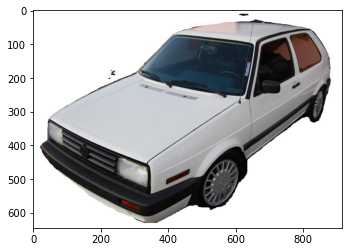

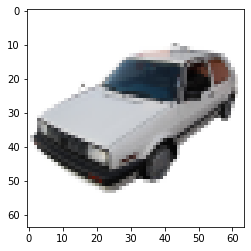

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
filtered_00881.jpg
render elevation is 15
pose elevation is 15


In [9]:
IMG_ID = -4
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

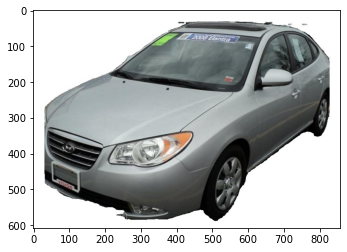

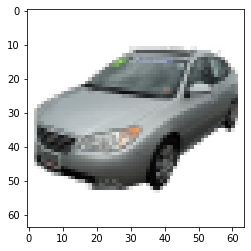

filtered_00376.jpg
render elevation is 15
pose elevation is 15


In [15]:
IMG_ID = -1
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

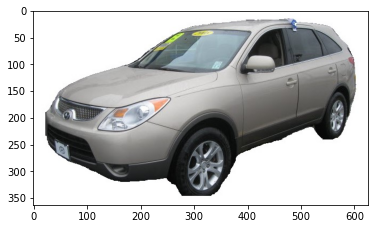

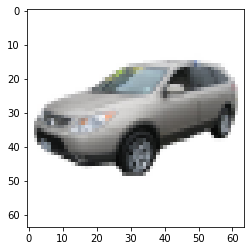

filtered_00034.jpg
render elevation is 15
pose elevation is 15


In [10]:
IMG_ID = -3
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

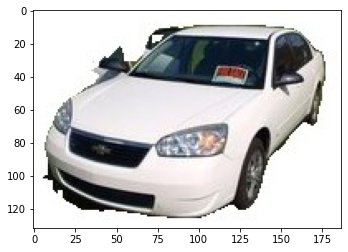

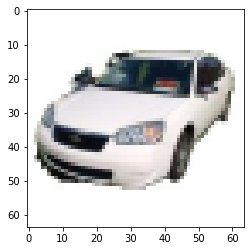

filtered_00018.jpg
render elevation is 15
pose elevation is 15


In [11]:
IMG_ID = -2
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

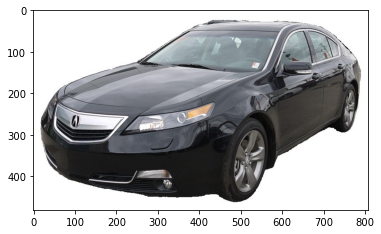

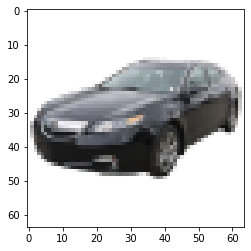

filtered_00002.jpg
render elevation is 15
pose elevation is 15


In [12]:
IMG_ID = -1
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

Define render poses and carry out actual renderings

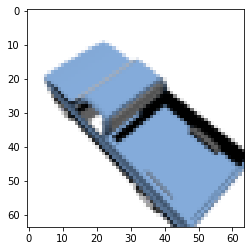

200000_ground_truth_val.png
render elevation is 30
pose elevation is 50


In [68]:
plt.imshow(images[0])
plt.show()
show_rendering(30,50, img_name=img_names[IMG_ID])

# -6.810337305068969727e-01 6.217651963233947754e-01 -3.867827951908111572e-01 -3.867829144001007080e-01
# -7.322519421577453613e-01 -5.782750248908996582e-01 3.597289621829986572e-01 3.597287535667419434e-01
# 1.011742511991542415e-07 5.282100439071655273e-01 8.491137027740478516e-01 8.491137623786926270e-01
# 0.000000000000000000e+00 0.000000000000000000e+00 0.000000000000000000e+00 1.000000000000000000e+00

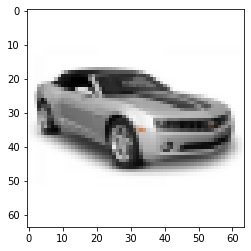

00076.jpg
render elevation is 15
pose elevation is 15


In [76]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

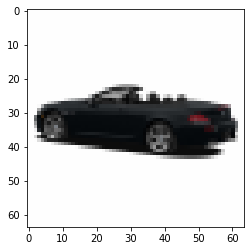

00022.jpg
render elevation is 15
pose elevation is 15


In [74]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

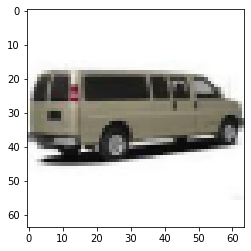

00169.jpg
render elevation is 15
pose elevation is 15


In [78]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

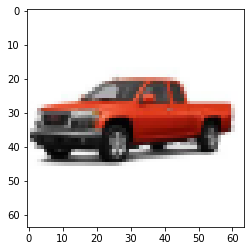

00178.jpg
render elevation is 15
pose elevation is 15


In [80]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

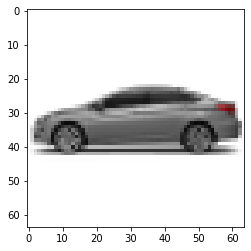

00472.jpg
render elevation is 15
pose elevation is 15


In [82]:
plt.imshow(images[0])
plt.show()
show_rendering(15,15, img_name=img_names[IMG_ID])

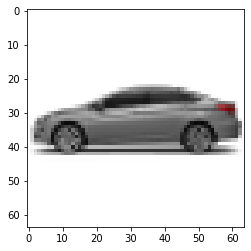

00472.jpg
render elevation is 0
pose elevation is 0


In [83]:
plt.imshow(images[0])
plt.show()
show_rendering(0,0, img_name=img_names[IMG_ID])

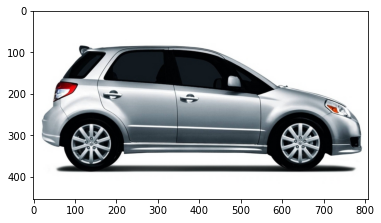

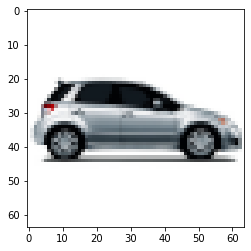

00475.jpg
render elevation is 0
pose elevation is 0


In [87]:
IMG_ID = 9
images = load_images(IMG_ID)
show_rendering(0,0, img_name=img_names[IMG_ID])

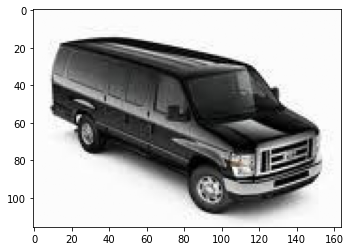

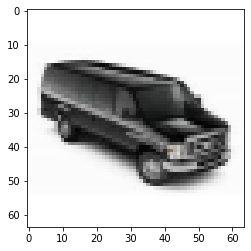

00949.jpg
render elevation is 45
pose elevation is 45


In [92]:
IMG_ID = 17
images = load_images(IMG_ID)
show_rendering(45,45, img_name=img_names[IMG_ID])

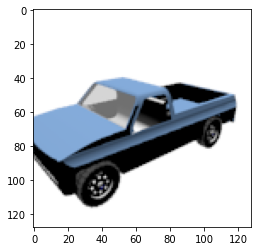

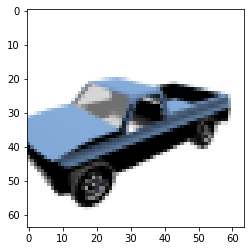

blender-005643.color.png
render elevation is 50
pose elevation is 50


In [99]:
IMG_ID = 18
images = load_images(IMG_ID)
show_rendering(50,50, img_name=img_names[IMG_ID])

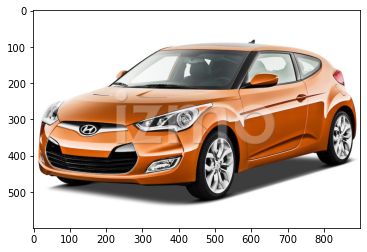

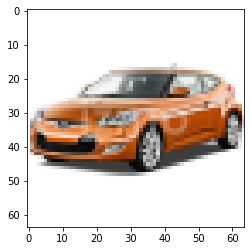

00563.jpg
render elevation is 30
pose elevation is 30


In [98]:
IMG_ID = 15
images = load_images(IMG_ID)
show_rendering(30,30, img_name=img_names[IMG_ID])

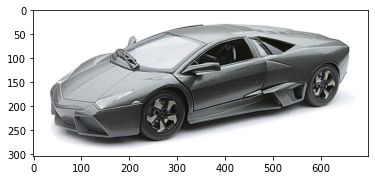

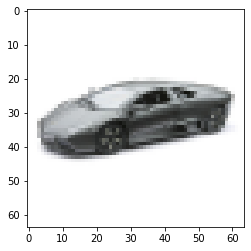

01066.jpg
render elevation is 15
pose elevation is 15


In [100]:
IMG_ID = 14
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])

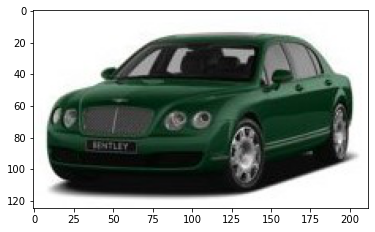

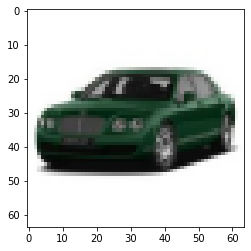

00896.jpg
render elevation is 15
pose elevation is 15


In [101]:
IMG_ID = 16
images = load_images(IMG_ID)
show_rendering(15,15, img_name=img_names[IMG_ID])